In [5]:
train_data_path = "/content/drive/MyDrive/Imagenet_data/train" ## my training and test dataset path 
test_data_path = "/content/drive/MyDrive/Imagenet_data/val"    

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
model_name = "inception_v3" ## inception v3 network  is called by the following link  by using tensorflow hub module 
model_handle_map = {
    "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
}

model_image_size_map = { "inception_v3":299} 
    
model_handle = model_handle_map.get(model_name) 
pixels = model_image_size_map.get(model_name, 299)   ## extracting pixel size
print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 

Selected model: inception_v3 : https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5
Input size (299, 299)


In [3]:
def build_dataset(subset):  ## defining a function to extract subset of the dataset
  return tf.keras.preprocessing.image_dataset_from_directory(   
      train_data_path,                 ##  dataset path
      validation_split=.20,           ## spliting dataset by 20% as validation data
      subset=subset,
      label_mode="categorical",       ## since we have 10 categorical data
                               # Seed needs to provided when using validation_split.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)         ## to extract image one by one
  

In [6]:
train_ds = build_dataset("training")   ## calling build data set function to separate traing data from validation data
class_names = tuple(train_ds.class_names)   ## Extracting class name 
train_size = train_ds.cardinality().numpy()   ## this use to calculate iterables
train_ds = train_ds.unbatch().batch(BATCH_SIZE) ## 1st unbundle all the images then bunble with batch size size ie 32
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(

    1. / 255)           ## scaling each image by dividing its max intensity value 
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False  

Found 9503 files belonging to 10 classes.
Using 7603 files for training.


In [7]:
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels)) ## iterating each image & label from train_ds  

val_ds = build_dataset("validation")    
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 9503 files belonging to 10 classes.
Using 1900 files for validation.


In [8]:
do_fine_tuning = False

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)), ## making input size same dimension as the inception v3 architecture 
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),   ## rendomly removing some node for better accuracy so that system doesnot do overfitting
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)) ## used l2 regulizer to regulate weights
])
model.build((None,)+IMAGE_SIZE+(3,)) ## 3 is the no. of channel of an image RGB
model.summary()    

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),   ## optimizer stochastic gradient descent lr is the learning rate
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),   ## calculating loss 
  metrics=['accuracy'])  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
steps_per_epoch = train_size // BATCH_SIZE   ## to reduce load 
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=1, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

 70/237 [=======>......................] - ETA: 13:55 - loss: 0.9501 - accuracy: 0.8531

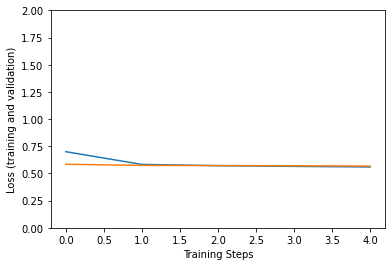

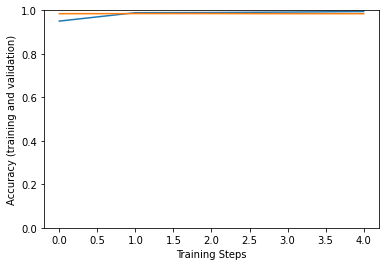

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")  
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

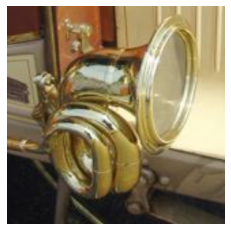

True label: n03394916
Predicted label: n03394916


In [ ]:
x, y = next(iter(val_ds))
h=1
image = x[h, :, :, :] ## h is the index of the images
true_index = np.argmax(y[h]) ##  showing onlyb the maximum value as predicted lebal
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

##FOR TEST

In [ ]:
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
      test_data_path,
      validation_split= None,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)


class_names = tuple(test_ds.class_names)
test_size = test_ds.cardinality().numpy()
test_ds = test_ds.unbatch().batch(BATCH_SIZE)
test_ds = test_ds.repeat()

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(

    1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False

test_ds = test_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


x, y = next(iter(test_ds))
d = 0
image = x[d, :, :, :]
true_index = np.argmax(y[d])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])